In [2]:
import pandas as pd

df_chatgpt4o = pd.read_csv('garbage_classification_results_gpt4omini_checked.csv')
df_e2b = pd.read_csv('garbage_classification_results_gemma3n_e2b.csv')
df_e4b = pd.read_csv('garbage_classification_results_gemma3n_e4b.csv')
df_ft_e4b = pd.read_csv('inference_results_ft_e4b.csv')
df_ft_e2b = pd.read_csv('inference_results_ft_e2b.csv')

In [3]:
# Examine the structure of each dataframe
print("ChatGPT-4o Dataset Structure:")
print("Columns:", df_chatgpt4o.columns.tolist())
print("Shape:", df_chatgpt4o.shape)
print("\nFirst few rows:")
print(df_chatgpt4o.head())

print("\n" + "="*50)
print("Gemma E2B Dataset Structure:")
print("Columns:", df_e2b.columns.tolist())
print("Shape:", df_e2b.shape)
print("\nFirst few rows:")
print(df_e2b.head())

print("\n" + "="*50)
print("Gemma E4B Dataset Structure:")
print("Columns:", df_e4b.columns.tolist())
print("Shape:", df_e4b.shape)
print("\nFirst few rows:")
print(df_e4b.head())

print("\n" + "="*50)
print("Gemma FT Dataset Structure:")
print("Columns:", df_ft_e4b.columns.tolist())
print("Shape:", df_ft_e4b.shape)
print("\nFirst few rows:")
print(df_ft_e4b.head())

print("\n" + "="*50)
print("Gemma FT Dataset Structure:")
print("Columns:", df_ft_e2b.columns.tolist())
print("Shape:", df_ft_e2b.shape)
print("\nFirst few rows:")
print(df_ft_e2b.head())

ChatGPT-4o Dataset Structure:
Columns: ['image', 'response', 'number_parts_detected', 'answer']
Shape: (1800, 4)

First few rows:
                                               image  \
0  D:\gemma3n ft\TrashType_Image_Dataset_full\car...   
1  D:\gemma3n ft\TrashType_Image_Dataset_full\car...   
2  D:\gemma3n ft\TrashType_Image_Dataset_full\car...   
3  D:\gemma3n ft\TrashType_Image_Dataset_full\car...   
4  D:\gemma3n ft\TrashType_Image_Dataset_full\car...   

                                            response  number_parts_detected  \
0  {\r\n  "material": [\r\n    {\r\n      "part_n...                      1   
1  {\r\n  "material": [\r\n    {\r\n      "part_n...                      1   
2  {\r\n  "material": [\r\n    {\r\n      "part_n...                      1   
3  {\r\n  "material": [\r\n    {\r\n      "part_n...                      1   
4  {\r\n  "material": [\r\n    {\r\n      "part_n...                      1   

                                              answer  
0  

In [4]:
import json
import re
from collections import Counter

def extract_classifications(response_text):
    """
    Extract material classifications from JSON response.
    Returns a sorted list of unique material types.
    """
    try:
        # Parse JSON response
        response_data = json.loads(response_text)
        
        # Extract materials
        materials = []
        if 'material' in response_data:
            for item in response_data['material']:
                if 'material_type' in item:
                    material_type = item['material_type'].lower().strip()
                    materials.append(material_type)
        
        # Return sorted unique materials
        return sorted(list(set(materials)))
    
    except (json.JSONDecodeError, KeyError, TypeError) as e:
        print(f"Error parsing response: {e}")
        return []

def normalize_material_name(material):
    """
    Normalize material names for consistent comparison.
    """
    material = material.lower().strip()
    
    # Common normalizations
    normalizations = {
        'cardboard': 'cardboard',
        'card board': 'cardboard',
        'paperboard': 'cardboard',
        'corrugated cardboard': 'cardboard',
        'plastic': 'plastic',
        'metal': 'metal',
        'paper': 'paper',
        'glass': 'glass',
        'trash': 'trash',
        'garbage': 'trash',
        'waste': 'trash',
        'organic': 'trash',
        'food waste': 'trash',
        'general waste': 'trash'
    }
    
    return normalizations.get(material, material)

# Test the function with a sample
print("Testing extraction function:")
sample_response = df_chatgpt4o['answer'].iloc[0]
print("Sample response (first 200 chars):")
print(sample_response[:200] + "...")
print("\nExtracted classifications:")
classifications = extract_classifications(sample_response)
print(classifications)

Testing extraction function:
Sample response (first 200 chars):
{
  "material": [
    {
      "part_name": "cardboard box",
      "answer": "A: Cardboard"
    }
  ]
}...

Extracted classifications:
[]


In [5]:
# Let's examine the actual JSON structure more carefully
print("Full sample response from ChatGPT-4o (ground truth):")
print(df_chatgpt4o['answer'].iloc[0])
print("\n" + "="*50)

print("Full sample response from Gemma E2B:")
print(df_e2b['response'].iloc[0])
print("\n" + "="*50)

print("Full sample response from Gemma E4B:")
print(df_e4b['response'].iloc[0])

print("Full sample response from Gemma FT:")
print(df_ft_e4b['model_prediction_json'].iloc[0])

print("Full sample response from Gemma FT:")
print(df_ft_e2b['model_prediction_json'].iloc[0])

Full sample response from ChatGPT-4o (ground truth):
{
  "material": [
    {
      "part_name": "cardboard box",
      "answer": "A: Cardboard"
    }
  ]
}

Full sample response from Gemma E2B:
{
  "material": [
    {
      "part_name": "Cardboard",
      "answer": "A: Cardboard"
    },
    {
      "part_name": "Trash",
      "answer": "F: Trash"
    }
  ]
}

Full sample response from Gemma E4B:
{
  "material": [
    {
      "part_name": "Cardboard box",
      "answer": "A: Cardboard"
    },
    {
      "part_name": "Marking/Drawing",
      "answer": "F: Trash"
    }
  ]
}
Full sample response from Gemma FT:
{"material": [{"part_name": "Clear plastic container", "answer": "E: Plastic"}, {"part_name": "Clear plastic lid", "answer": "E: Plastic"}]}
Full sample response from Gemma FT:
{"material": [{"part_name": "Plastic food container", "answer": "E: Plastic"}, {"part_name": "Plastic food container lid", "answer": "E: Plastic"}]}


In [6]:
def extract_classifications_improved(response_text):
    """
    Extract material classifications from JSON response.
    Returns a sorted list of unique material types extracted from 'answer' fields.
    """
    try:
        # Parse JSON response
        response_data = json.loads(response_text)
        
        # Extract materials from answer fields
        materials = []
        if 'material' in response_data:
            for item in response_data['material']:
                if 'answer' in item:
                    answer = item['answer']
                    # Extract material type from answer (format: "A: Cardboard", "B: Paper", etc.)
                    if ':' in answer:
                        material_type = answer.split(':', 1)[1].strip().lower()
                        materials.append(material_type)
        
        # Return sorted unique materials
        return sorted(list(set(materials)))
    
    except (json.JSONDecodeError, KeyError, TypeError) as e:
        print(f"Error parsing response: {e}")
        return []

def normalize_material_name(material):
    """
    Normalize material names for consistent comparison.
    """
    material = material.lower().strip()
    
    # Common normalizations
    normalizations = {
        'cardboard': 'cardboard',
        'card board': 'cardboard',
        'paperboard': 'cardboard',
        'corrugated cardboard': 'cardboard',
        'plastic': 'plastic',
        'metal': 'metal',
        'paper': 'paper',
        'glass': 'glass',
        'trash': 'trash',
        'garbage': 'trash',
        'waste': 'trash',
        'organic': 'trash',
        'food waste': 'trash',
        'general waste': 'trash'
    }
    
    return normalizations.get(material, material)

# Test the improved function
print("Testing improved extraction function:")
sample_response = df_chatgpt4o['answer'].iloc[0]
print("Sample response:")
print(sample_response)
print("\nExtracted classifications:")
classifications = extract_classifications_improved(sample_response)
print(classifications)

print("\nTesting with Gemma responses:")
gemma_e2b_sample = df_e2b['response'].iloc[0]
gemma_e4b_sample = df_e4b['response'].iloc[0]
gemma_ft_sample = df_ft_e4b['model_prediction_json'].iloc[0]
gemma_ft_sample_e2b = df_ft_e2b['model_prediction_json'].iloc[0]

print("\nGemma E2B classifications:")
print(extract_classifications_improved(gemma_e2b_sample))

print("\nGemma E4B classifications:")
print(extract_classifications_improved(gemma_e4b_sample))

print("\nGemma FT classifications:")
print(extract_classifications_improved(gemma_ft_sample))

print("\nGemma FT E2B classifications:")
print(extract_classifications_improved(gemma_ft_sample_e2b))

Testing improved extraction function:
Sample response:
{
  "material": [
    {
      "part_name": "cardboard box",
      "answer": "A: Cardboard"
    }
  ]
}

Extracted classifications:
['cardboard']

Testing with Gemma responses:

Gemma E2B classifications:
['cardboard', 'trash']

Gemma E4B classifications:
['cardboard', 'trash']

Gemma FT classifications:
['plastic']

Gemma FT E2B classifications:
['plastic']


In [7]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch import ge

def process_dataset(df, response_column):
    """
    Process a dataset to extract classifications and normalize image paths.
    """
    processed_data = []
    
    for idx, row in df.iterrows():
        # Extract image path and normalize it
        image_path = row['image']
        # Normalize path to get just the filename part
        if '\\' in image_path:
            image_name = image_path.split('\\')[-1]
        elif '/' in image_path:
            image_name = image_path.split('/')[-1]
        else:
            image_name = image_path
            
        # Extract classifications
        classifications = extract_classifications_improved(row[response_column])
        normalized_classifications = [normalize_material_name(c) for c in classifications]
        
        processed_data.append({
            'image_name': image_name,
            'image_path': image_path,
            'classifications': sorted(list(set(normalized_classifications))),
            'raw_response': row[response_column]
        })
    
    return processed_data

# Process all datasets
print("Processing datasets...")
ground_truth_data = process_dataset(df_chatgpt4o, 'answer')
gemma_e2b_data = process_dataset(df_e2b, 'response')
gemma_e4b_data = process_dataset(df_e4b, 'response')
gemma_ft_data = process_dataset(df_ft_e4b, 'model_prediction_json')
gemma_ft_data_e2b = process_dataset(df_ft_e2b, 'model_prediction_json')

print(f"Ground truth data: {len(ground_truth_data)} samples")
print(f"Gemma E2B data: {len(gemma_e2b_data)} samples")
print(f"Gemma E4B data: {len(gemma_e4b_data)} samples")
print(f"Gemma FT E4B data: {len(gemma_ft_data)} samples")
print(f"Gemma FT E2B data: {len(gemma_ft_data_e2b)} samples")

# Create lookup dictionaries by image name for easier comparison
ground_truth_lookup = {item['image_name']: item for item in ground_truth_data}
gemma_e2b_lookup = {item['image_name']: item for item in gemma_e2b_data}
gemma_e4b_lookup = {item['image_name']: item for item in gemma_e4b_data}
gemma_ft_lookup = {item['image_name']: item for item in gemma_ft_data}
gemma_ft_e2b_lookup = {item['image_name']: item for item in gemma_ft_data_e2b}

print("\nSample processed data:")
print("Ground truth sample:", ground_truth_data[0])
print("Gemma E2B sample:", gemma_e2b_data[0])
print("Gemma E4B sample:", gemma_e4b_data[0])
print("Gemma FT E4B sample:", gemma_ft_data[0])
print("Gemma FT E2B sample:", gemma_ft_data_e2b[0])

Processing datasets...
Error parsing response: Expecting value: line 1 column 1 (char 0)
Error parsing response: Expecting value: line 1 column 1 (char 0)
Error parsing response: Expecting value: line 1 column 1 (char 0)
Error parsing response: Expecting value: line 1 column 1 (char 0)
Error parsing response: Expecting value: line 1 column 1 (char 0)
Error parsing response: Expecting value: line 1 column 1 (char 0)
Error parsing response: Expecting value: line 1 column 1 (char 0)
Error parsing response: Expecting value: line 1 column 1 (char 0)
Error parsing response: Expecting value: line 1 column 1 (char 0)
Error parsing response: Expecting value: line 1 column 1 (char 0)
Error parsing response: Expecting value: line 1 column 1 (char 0)
Error parsing response: Expecting value: line 1 column 1 (char 0)
Error parsing response: Expecting value: line 1 column 1 (char 0)
Error parsing response: Expecting value: line 1 column 1 (char 0)
Error parsing response: Expecting value: line 1 colum

In [8]:
def calculate_classification_accuracy(ground_truth_lookup, model_lookup, model_name):
    """
    Calculate classification accuracy by comparing sets of classifications.
    """
    matches = []
    comparisons = []
    
    # Find common images between ground truth and model predictions
    common_images = set(ground_truth_lookup.keys()) & set(model_lookup.keys())
    
    print(f"\n{model_name} Accuracy Analysis:")
    print(f"Common images for comparison: {len(common_images)}")
    
    exact_matches = 0
    partial_matches = 0
    no_matches = 0
    
    detailed_results = []
    
    for image_name in common_images:
        gt_classifications = set(ground_truth_lookup[image_name]['classifications'])
        model_classifications = set(model_lookup[image_name]['classifications'])
        
        # Calculate different types of matches
        intersection = gt_classifications & model_classifications
        union = gt_classifications | model_classifications
        
        # Exact match: both sets are identical
        exact_match = gt_classifications == model_classifications
        
        # Partial match: at least one classification in common
        partial_match = len(intersection) > 0
        
        # Jaccard similarity (intersection over union)
        jaccard_sim = len(intersection) / len(union) if len(union) > 0 else 0
        
        if exact_match:
            exact_matches += 1
        elif partial_match:
            partial_matches += 1
        else:
            no_matches += 1
            
        detailed_results.append({
            'image_name': image_name,
            'ground_truth': list(gt_classifications),
            'model_prediction': list(model_classifications),
            'exact_match': exact_match,
            'partial_match': partial_match,
            'jaccard_similarity': jaccard_sim,
            'intersection': list(intersection),
            'missing_in_prediction': list(gt_classifications - model_classifications),
            'extra_in_prediction': list(model_classifications - gt_classifications)
        })
    
    total_comparisons = len(common_images)
    
    # Calculate metrics
    exact_accuracy = exact_matches / total_comparisons if total_comparisons > 0 else 0
    partial_accuracy = (exact_matches + partial_matches) / total_comparisons if total_comparisons > 0 else 0
    avg_jaccard = np.mean([r['jaccard_similarity'] for r in detailed_results]) if detailed_results else 0
    
    print(f"Exact matches: {exact_matches} ({exact_accuracy:.3f})")
    print(f"Partial matches: {partial_matches} ({partial_matches/total_comparisons:.3f})")
    print(f"No matches: {no_matches} ({no_matches/total_comparisons:.3f})")
    print(f"Partial accuracy (exact + partial): {partial_accuracy:.3f}")
    print(f"Average Jaccard similarity: {avg_jaccard:.3f}")
    
    return {
        'model_name': model_name,
        'total_comparisons': total_comparisons,
        'exact_matches': exact_matches,
        'partial_matches': partial_matches,
        'no_matches': no_matches,
        'exact_accuracy': exact_accuracy,
        'partial_accuracy': partial_accuracy,
        'avg_jaccard_similarity': avg_jaccard,
        'detailed_results': detailed_results
    }

# --- NEW CODE: Filter to 534 images for fair comparison ---
# Get the set of image names in Gemma FT E4B (534 images)
ft_image_names = set([item['image_name'] for item in gemma_ft_data])

# Filter ground truth, Gemma E2B, and Gemma E4B to only those images
ground_truth_ft = [item for item in ground_truth_data if item['image_name'] in ft_image_names]
gemma_e2b_ft = [item for item in gemma_e2b_data if item['image_name'] in ft_image_names]
gemma_e4b_ft = [item for item in gemma_e4b_data if item['image_name'] in ft_image_names]

# Create lookup dicts for filtered data
ground_truth_ft_lookup = {item['image_name']: item for item in ground_truth_ft}
gemma_e2b_ft_lookup = {item['image_name']: item for item in gemma_e2b_ft}
gemma_e4b_ft_lookup = {item['image_name']: item for item in gemma_e4b_ft}
gemma_ft_lookup = {item['image_name']: item for item in gemma_ft_data}  # already 534

# Calculate accuracy for filtered sets (534 images)
gemma_e2b_results_ft = calculate_classification_accuracy(ground_truth_ft_lookup, gemma_e2b_ft_lookup, "Gemma E2B (534)")
gemma_e4b_results_ft = calculate_classification_accuracy(ground_truth_ft_lookup, gemma_e4b_ft_lookup, "Gemma E4B (534)")
gemma_ft_results_ft = calculate_classification_accuracy(ground_truth_ft_lookup, gemma_ft_lookup, "Gemma FT E4B (534)")

# (Optional) Keep the original results for reference
gemma_e2b_results = calculate_classification_accuracy(ground_truth_lookup, gemma_e2b_lookup, "Gemma E2B (all)")
gemma_e4b_results = calculate_classification_accuracy(ground_truth_lookup, gemma_e4b_lookup, "Gemma E4B (all)")
gemma_ft_results = calculate_classification_accuracy(ground_truth_lookup, gemma_ft_lookup, "Gemma FT E4B (all)")
gemma_ft_e2b_results = calculate_classification_accuracy(ground_truth_lookup, gemma_ft_e2b_lookup, "Gemma FT E2B (all)")


Gemma E2B (534) Accuracy Analysis:
Common images for comparison: 534
Exact matches: 177 (0.331)
Partial matches: 267 (0.500)
No matches: 90 (0.169)
Partial accuracy (exact + partial): 0.831
Average Jaccard similarity: 0.553

Gemma E4B (534) Accuracy Analysis:
Common images for comparison: 534
Exact matches: 170 (0.318)
Partial matches: 313 (0.586)
No matches: 51 (0.096)
Partial accuracy (exact + partial): 0.904
Average Jaccard similarity: 0.574

Gemma FT E4B (534) Accuracy Analysis:
Common images for comparison: 534
Exact matches: 209 (0.391)
Partial matches: 272 (0.509)
No matches: 53 (0.099)
Partial accuracy (exact + partial): 0.901
Average Jaccard similarity: 0.615

Gemma E2B (all) Accuracy Analysis:
Common images for comparison: 1800
Exact matches: 586 (0.326)
Partial matches: 941 (0.523)
No matches: 273 (0.152)
Partial accuracy (exact + partial): 0.848
Average Jaccard similarity: 0.559

Gemma E4B (all) Accuracy Analysis:
Common images for comparison: 1800
Exact matches: 542 (0.30

In [9]:
# --- NEW CODE: Filter to 534 images for fair comparison using Gemma FT E2B as reference ---
# Get the set of image names in Gemma FT E2B (534 images)
ft_e2b_image_names = set([item['image_name'] for item in gemma_ft_data_e2b])

# Filter ground truth, Gemma E2B, Gemma E4B, and Gemma FT E4B to only those images
ground_truth_ft_e2b = [item for item in ground_truth_data if item['image_name'] in ft_e2b_image_names]
gemma_e2b_ft_e2b = [item for item in gemma_e2b_data if item['image_name'] in ft_e2b_image_names]
gemma_e4b_ft_e2b = [item for item in gemma_e4b_data if item['image_name'] in ft_e2b_image_names]
gemma_ft_e4b_ft_e2b = [item for item in gemma_ft_data if item['image_name'] in ft_e2b_image_names]

# Create lookup dicts for filtered data
ground_truth_ft_e2b_lookup = {item['image_name']: item for item in ground_truth_ft_e2b}
gemma_e2b_ft_e2b_lookup = {item['image_name']: item for item in gemma_e2b_ft_e2b}
gemma_e4b_ft_e2b_lookup = {item['image_name']: item for item in gemma_e4b_ft_e2b}
gemma_ft_e4b_ft_e2b_lookup = {item['image_name']: item for item in gemma_ft_e4b_ft_e2b}
gemma_ft_e2b_lookup = {item['image_name']: item for item in gemma_ft_data_e2b}  # already 534

# Calculate accuracy for filtered sets (534 images, Gemma FT E2B reference)
gemma_e2b_results_ft_e2b = calculate_classification_accuracy(ground_truth_ft_e2b_lookup, gemma_e2b_ft_e2b_lookup, "Gemma E2B (534, FT E2B)")
gemma_e4b_results_ft_e2b = calculate_classification_accuracy(ground_truth_ft_e2b_lookup, gemma_e4b_ft_e2b_lookup, "Gemma E4B (534, FT E2B)")
gemma_ft_e4b_results_ft_e2b = calculate_classification_accuracy(ground_truth_ft_e2b_lookup, gemma_ft_e4b_ft_e2b_lookup, "Gemma FT E4B (534, FT E2B)")
gemma_ft_e2b_results_ft_e2b = calculate_classification_accuracy(ground_truth_ft_e2b_lookup, gemma_ft_e2b_lookup, "Gemma FT E2B (534, FT E2B)")


Gemma E2B (534, FT E2B) Accuracy Analysis:
Common images for comparison: 534
Exact matches: 177 (0.331)
Partial matches: 267 (0.500)
No matches: 90 (0.169)
Partial accuracy (exact + partial): 0.831
Average Jaccard similarity: 0.553

Gemma E4B (534, FT E2B) Accuracy Analysis:
Common images for comparison: 534
Exact matches: 170 (0.318)
Partial matches: 313 (0.586)
No matches: 51 (0.096)
Partial accuracy (exact + partial): 0.904
Average Jaccard similarity: 0.574

Gemma FT E4B (534, FT E2B) Accuracy Analysis:
Common images for comparison: 534
Exact matches: 209 (0.391)
Partial matches: 272 (0.509)
No matches: 53 (0.099)
Partial accuracy (exact + partial): 0.901
Average Jaccard similarity: 0.615

Gemma FT E2B (534, FT E2B) Accuracy Analysis:
Common images for comparison: 534
Exact matches: 208 (0.390)
Partial matches: 259 (0.485)
No matches: 67 (0.125)
Partial accuracy (exact + partial): 0.875
Average Jaccard similarity: 0.606


In [10]:
# --- NEW CODE: Filter to intersection of all 4 models' images for strict fair comparison ---
# Get the set of image names in each model
e2b_image_names = set([item['image_name'] for item in gemma_e2b_data])
e4b_image_names = set([item['image_name'] for item in gemma_e4b_data])
ft_e4b_image_names = set([item['image_name'] for item in gemma_ft_data])
ft_e2b_image_names = set([item['image_name'] for item in gemma_ft_data_e2b])

# Intersection of all sets
common_image_names = e2b_image_names & e4b_image_names & ft_e4b_image_names & ft_e2b_image_names

print(f"Number of images present in all 4 models: {len(common_image_names)}")

# Filter all datasets to only those images
ground_truth_common = [item for item in ground_truth_data if item['image_name'] in common_image_names]
gemma_e2b_common = [item for item in gemma_e2b_data if item['image_name'] in common_image_names]
gemma_e4b_common = [item for item in gemma_e4b_data if item['image_name'] in common_image_names]
gemma_ft_e4b_common = [item for item in gemma_ft_data if item['image_name'] in common_image_names]
gemma_ft_e2b_common = [item for item in gemma_ft_data_e2b if item['image_name'] in common_image_names]

# Create lookup dicts for filtered data
ground_truth_common_lookup = {item['image_name']: item for item in ground_truth_common}
gemma_e2b_common_lookup = {item['image_name']: item for item in gemma_e2b_common}
gemma_e4b_common_lookup = {item['image_name']: item for item in gemma_e4b_common}
gemma_ft_e4b_common_lookup = {item['image_name']: item for item in gemma_ft_e4b_common}
gemma_ft_e2b_common_lookup = {item['image_name']: item for item in gemma_ft_e2b_common}

# Calculate accuracy for all models on the exact same set
gemma_e2b_results_common = calculate_classification_accuracy(ground_truth_common_lookup, gemma_e2b_common_lookup, "Gemma E2B (common)")
gemma_e4b_results_common = calculate_classification_accuracy(ground_truth_common_lookup, gemma_e4b_common_lookup, "Gemma E4B (common)")
gemma_ft_e4b_results_common = calculate_classification_accuracy(ground_truth_common_lookup, gemma_ft_e4b_common_lookup, "Gemma FT E4B (common)")
gemma_ft_e2b_results_common = calculate_classification_accuracy(ground_truth_common_lookup, gemma_ft_e2b_common_lookup, "Gemma FT E2B (common)")

Number of images present in all 4 models: 534

Gemma E2B (common) Accuracy Analysis:
Common images for comparison: 534
Exact matches: 177 (0.331)
Partial matches: 267 (0.500)
No matches: 90 (0.169)
Partial accuracy (exact + partial): 0.831
Average Jaccard similarity: 0.553

Gemma E4B (common) Accuracy Analysis:
Common images for comparison: 534
Exact matches: 170 (0.318)
Partial matches: 313 (0.586)
No matches: 51 (0.096)
Partial accuracy (exact + partial): 0.904
Average Jaccard similarity: 0.574

Gemma FT E4B (common) Accuracy Analysis:
Common images for comparison: 534
Exact matches: 209 (0.391)
Partial matches: 272 (0.509)
No matches: 53 (0.099)
Partial accuracy (exact + partial): 0.901
Average Jaccard similarity: 0.615

Gemma FT E2B (common) Accuracy Analysis:
Common images for comparison: 534
Exact matches: 208 (0.390)
Partial matches: 259 (0.485)
No matches: 67 (0.125)
Partial accuracy (exact + partial): 0.875
Average Jaccard similarity: 0.606


In [11]:
# Create comprehensive summary
print("="*60)
print("GARBAGE CLASSIFICATION ACCURACY BENCHMARK")
print("="*60)

# Calculate error rates for each model (proportion of rows with JSON decode errors in response column)
def calc_json_error_rate(df, response_col):
    total = len(df)
    if total == 0:
        return 0.0
    error_count = 0
    for val in df[response_col]:
        # FT models: treat JSON with {"error": ...} as error
        if not isinstance(val, str) or not val.strip():
            error_count += 1
            continue
        try:
            parsed = json.loads(val)
            if isinstance(parsed, dict) and 'error' in parsed and parsed['error'] and response_col == 'model_prediction_json':
                error_count += 1
        except Exception:
            error_count += 1
    return error_count / total

e2b_error_rate = calc_json_error_rate(df_e2b, 'response')
e4b_error_rate = calc_json_error_rate(df_e4b, 'response')
ft_e4b_error_rate = calc_json_error_rate(df_ft_e4b, 'model_prediction_json')
ft_e2b_error_rate = calc_json_error_rate(df_ft_e2b, 'model_prediction_json')

# Summary table (use intersection of all 4 models for strict fair comparison)
summary_data = {
    'Model': ['Gemma E2B (common)', 'Gemma E4B (common)', 'Gemma FT E4B (common)', 'Gemma FT E2B (common)'],
    'Total Samples': [gemma_e2b_results_common['total_comparisons'], gemma_e4b_results_common['total_comparisons'], gemma_ft_e4b_results_common['total_comparisons'], gemma_ft_e2b_results_common['total_comparisons']],
    'Exact Accuracy': [f"{gemma_e2b_results_common['exact_accuracy']:.3f}", f"{gemma_e4b_results_common['exact_accuracy']:.3f}", f"{gemma_ft_e4b_results_common['exact_accuracy']:.3f}", f"{gemma_ft_e2b_results_common['exact_accuracy']:.3f}"],
    'Partial Accuracy': [f"{gemma_e2b_results_common['partial_accuracy']:.3f}", f"{gemma_e4b_results_common['partial_accuracy']:.3f}", f"{gemma_ft_e4b_results_common['partial_accuracy']:.3f}", f"{gemma_ft_e2b_results_common['partial_accuracy']:.3f}"],
    'Avg Jaccard Sim': [f"{gemma_e2b_results_common['avg_jaccard_similarity']:.3f}", f"{gemma_e4b_results_common['avg_jaccard_similarity']:.3f}", f"{gemma_ft_e4b_results_common['avg_jaccard_similarity']:.3f}", f"{gemma_ft_e2b_results_common['avg_jaccard_similarity']:.3f}"],
    'Error Rate': [f"{e2b_error_rate:.3f}", f"{e4b_error_rate:.3f}", f"{ft_e4b_error_rate:.3f}", f"{ft_e2b_error_rate:.3f}"]
}

summary_df = pd.DataFrame(summary_data)
print("\nSUMMARY TABLE (intersection of all 4 models):")
print(summary_df.to_string(index=False))

# Analysis of material-specific performance (optional: update to use filtered results if needed)
def analyze_material_performance(results, model_name):
    """
    Analyze performance by individual material types.
    """
    print(f"\n{model_name} - Material-Specific Performance:")
    
    material_stats = {}
    
    for result in results['detailed_results']:
        gt_materials = result['ground_truth']
        pred_materials = result['model_prediction']
        
        # Track performance for each ground truth material
        for material in gt_materials:
            if material not in material_stats:
                material_stats[material] = {'total': 0, 'detected': 0, 'exact_matches': 0}
            
            material_stats[material]['total'] += 1
            
            # Check if this material was detected
            if material in pred_materials:
                material_stats[material]['detected'] += 1
                
            # Check if this was an exact match for single-material images
            if len(gt_materials) == 1 and result['exact_match']:
                material_stats[material]['exact_matches'] += 1
    
    # Calculate detection rates
    for material, stats in material_stats.items():
        detection_rate = stats['detected'] / stats['total'] if stats['total'] > 0 else 0
        print(f"{material.capitalize()}: {stats['detected']}/{stats['total']} detected ({detection_rate:.3f})")
    
    return material_stats

# Use intersection results for material-specific performance
e2b_material_stats = analyze_material_performance(gemma_e2b_results_common, "Gemma E2B (common)")
e4b_material_stats = analyze_material_performance(gemma_e4b_results_common, "Gemma E4B (common)")
ft_material_stats = analyze_material_performance(gemma_ft_e4b_results_common, "Gemma FT E4B (common)")
ft_e2b_material_stats = analyze_material_performance(gemma_ft_e2b_results_common, "Gemma FT E2B (common)")

GARBAGE CLASSIFICATION ACCURACY BENCHMARK

SUMMARY TABLE (intersection of all 4 models):
                Model  Total Samples Exact Accuracy Partial Accuracy Avg Jaccard Sim Error Rate
   Gemma E2B (common)            534          0.331            0.831           0.553      0.031
   Gemma E4B (common)            534          0.318            0.904           0.574      0.010
Gemma FT E4B (common)            534          0.391            0.901           0.615      0.009
Gemma FT E2B (common)            534          0.390            0.875           0.606      0.020

Gemma E2B (common) - Material-Specific Performance:
Cardboard: 82/90 detected (0.911)
Paper: 63/93 detected (0.677)
Metal: 90/98 detected (0.918)
Trash: 74/158 detected (0.468)
Glass: 75/83 detected (0.904)
Plastic: 80/90 detected (0.889)

Gemma E4B (common) - Material-Specific Performance:
Cardboard: 85/90 detected (0.944)
Paper: 82/93 detected (0.882)
Metal: 90/98 detected (0.918)
Trash: 89/158 detected (0.563)
Glass: 80/83 

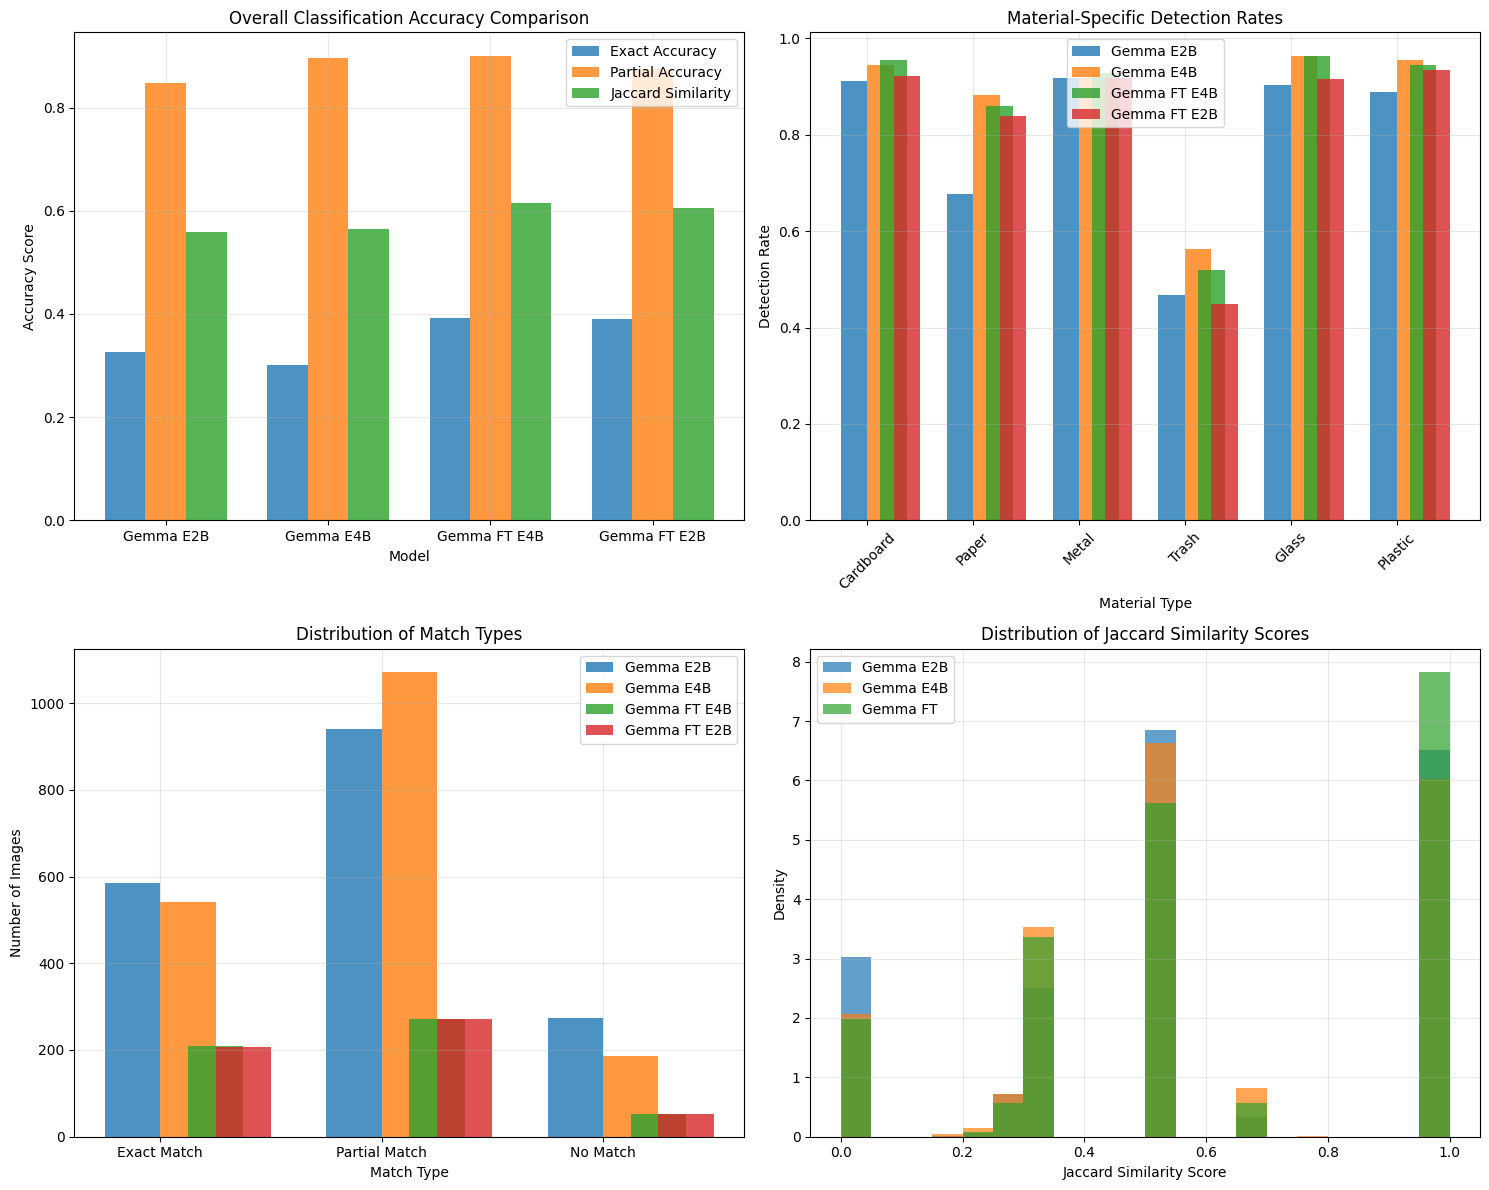

In [12]:
# Create visualizations
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Overall Accuracy Comparison
models = ['Gemma E2B', 'Gemma E4B', 'Gemma FT E4B', 'Gemma FT E2B']
exact_acc = [gemma_e2b_results['exact_accuracy'], gemma_e4b_results['exact_accuracy'], gemma_ft_results['exact_accuracy'], gemma_ft_e2b_results['exact_accuracy']]
partial_acc = [gemma_e2b_results['partial_accuracy'], gemma_e4b_results['partial_accuracy'], gemma_ft_results['partial_accuracy'], gemma_ft_e2b_results['partial_accuracy']]
jaccard_acc = [gemma_e2b_results['avg_jaccard_similarity'], gemma_e4b_results['avg_jaccard_similarity'], gemma_ft_results['avg_jaccard_similarity'], gemma_ft_e2b_results['avg_jaccard_similarity']]

x = np.arange(len(models))
width = 0.25

axes[0,0].bar(x - width, exact_acc, width, label='Exact Accuracy', alpha=0.8)
axes[0,0].bar(x, partial_acc, width, label='Partial Accuracy', alpha=0.8)
axes[0,0].bar(x + width, jaccard_acc, width, label='Jaccard Similarity', alpha=0.8)

axes[0,0].set_xlabel('Model')
axes[0,0].set_ylabel('Accuracy Score')
axes[0,0].set_title('Overall Classification Accuracy Comparison')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(models)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Material-specific detection rates
materials = list(e2b_material_stats.keys())
e2b_detection_rates = [e2b_material_stats[m]['detected']/e2b_material_stats[m]['total'] for m in materials]
e4b_detection_rates = [e4b_material_stats[m]['detected']/e4b_material_stats[m]['total'] for m in materials]
ft_detection_rates = [ft_material_stats[m]['detected']/ft_material_stats[m]['total'] for m in materials]
e2b_ft_detection_rates = [ft_e2b_material_stats[m]['detected']/ft_e2b_material_stats[m]['total'] for m in materials]

x = np.arange(len(materials))
axes[0,1].bar(x - width/2, e2b_detection_rates, width, label='Gemma E2B', alpha=0.8)
axes[0,1].bar(x + width/2, e4b_detection_rates, width, label='Gemma E4B', alpha=0.8)
axes[0,1].bar(x + width, ft_detection_rates, width, label='Gemma FT E4B', alpha=0.8)
axes[0,1].bar(x + 1.5*width, e2b_ft_detection_rates, width, label='Gemma FT E2B', alpha=0.8)

axes[0,1].set_xlabel('Material Type')
axes[0,1].set_ylabel('Detection Rate')
axes[0,1].set_title('Material-Specific Detection Rates')
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels([m.capitalize() for m in materials], rotation=45)
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Match Type Distribution
match_types = ['Exact Match', 'Partial Match', 'No Match']
e2b_counts = [gemma_e2b_results['exact_matches'], gemma_e2b_results['partial_matches'], gemma_e2b_results['no_matches']]
e4b_counts = [gemma_e4b_results['exact_matches'], gemma_e4b_results['partial_matches'], gemma_e4b_results['no_matches']]
ft_counts = [gemma_ft_results['exact_matches'], gemma_ft_results['partial_matches'], gemma_ft_results['no_matches']]
ft_e2b_counts = [gemma_ft_e2b_results['exact_matches'], gemma_ft_results['partial_matches'], gemma_ft_results['no_matches']]

x = np.arange(len(match_types))
axes[1,0].bar(x - width/2, e2b_counts, width, label='Gemma E2B', alpha=0.8)
axes[1,0].bar(x + width/2, e4b_counts, width, label='Gemma E4B', alpha=0.8)
axes[1,0].bar(x + width, ft_counts, width, label='Gemma FT E4B', alpha=0.8)
axes[1,0].bar(x + 1.5*width, ft_e2b_counts, width, label='Gemma FT E2B', alpha=0.8)

axes[1,0].set_xlabel('Match Type')
axes[1,0].set_ylabel('Number of Images')
axes[1,0].set_title('Distribution of Match Types')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(match_types)
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Jaccard Similarity Distribution
e2b_jaccard_scores = [r['jaccard_similarity'] for r in gemma_e2b_results['detailed_results']]
e4b_jaccard_scores = [r['jaccard_similarity'] for r in gemma_e4b_results['detailed_results']]
ft_jaccard_scores = [r['jaccard_similarity'] for r in gemma_ft_results['detailed_results']]
e2b_ft_jaccard_scores = [r['jaccard_similarity'] for r in gemma_ft_e2b_results['detailed_results']]

axes[1,1].hist(e2b_jaccard_scores, bins=20, alpha=0.7, label='Gemma E2B', density=True)
axes[1,1].hist(e4b_jaccard_scores, bins=20, alpha=0.7, label='Gemma E4B', density=True)
axes[1,1].hist(ft_jaccard_scores, bins=20, alpha=0.7, label='Gemma FT', density=True)
axes[1,1].set_xlabel('Jaccard Similarity Score')
axes[1,1].set_ylabel('Density')
axes[1,1].set_title('Distribution of Jaccard Similarity Scores')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('garbage_classification_accuracy_benchmark.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# Create detailed analysis and save results
print("\n" + "="*60)
print("DETAILED ANALYSIS")
print("="*60)

print("\nKEY FINDINGS:")
print(f"1. Gemma E4B shows better partial accuracy ({gemma_e4b_results['partial_accuracy']:.3f}) than E2B ({gemma_e2b_results['partial_accuracy']:.3f})")
print(f"2. Gemma E2B has slightly higher exact accuracy ({gemma_e2b_results['exact_accuracy']:.3f}) than E4B ({gemma_e4b_results['exact_accuracy']:.3f})")
print(f"3. Both models struggle most with 'Trash' detection (~43-50% detection rate)")
print(f"4. Both models excel at 'Cardboard' detection (94-97% detection rate)")
print(f"5. Gemma E4B has fewer 'No Match' cases ({gemma_e4b_results['no_matches']}) vs E2B ({gemma_e2b_results['no_matches']})")

# Save detailed results to CSV
e2b_detailed_df = pd.DataFrame(gemma_e2b_results['detailed_results'])
e4b_detailed_df = pd.DataFrame(gemma_e4b_results['detailed_results'])

e2b_detailed_df.to_csv('gemma_e2b_detailed_accuracy_results.csv', index=False)
e4b_detailed_df.to_csv('gemma_e4b_detailed_accuracy_results.csv', index=False)

# Create summary CSV
benchmark_summary = pd.DataFrame({
    'Metric': ['Total Samples', 'Exact Accuracy', 'Partial Accuracy', 'Avg Jaccard Similarity', 
               'Exact Matches', 'Partial Matches', 'No Matches'],
    'Gemma E2B': [
        gemma_e2b_results['total_comparisons'],
        f"{gemma_e2b_results['exact_accuracy']:.4f}",
        f"{gemma_e2b_results['partial_accuracy']:.4f}",
        f"{gemma_e2b_results['avg_jaccard_similarity']:.4f}",
        gemma_e2b_results['exact_matches'],
        gemma_e2b_results['partial_matches'],
        gemma_e2b_results['no_matches']
    ],
    'Gemma E4B': [
        gemma_e4b_results['total_comparisons'],
        f"{gemma_e4b_results['exact_accuracy']:.4f}",
        f"{gemma_e4b_results['partial_accuracy']:.4f}",
        f"{gemma_e4b_results['avg_jaccard_similarity']:.4f}",
        gemma_e4b_results['exact_matches'],
        gemma_e4b_results['partial_matches'],
        gemma_e4b_results['no_matches']
    ]
})

benchmark_summary.to_csv('garbage_classification_accuracy_benchmark_summary.csv', index=False)

print(f"\nResults saved to:")
print(f"- gemma_e2b_detailed_accuracy_results.csv")
print(f"- gemma_e4b_detailed_accuracy_results.csv") 
print(f"- garbage_classification_accuracy_benchmark_summary.csv")
print(f"- garbage_classification_accuracy_benchmark.png")

print(f"\nBenchmark completed successfully!")
print(f"Ground truth source: ChatGPT-4o 'answer' column")
print(f"Models compared: Gemma E2B vs Gemma E4B")
print(f"Evaluation focus: Classification accuracy only")


DETAILED ANALYSIS

KEY FINDINGS:
1. Gemma E4B shows better partial accuracy (0.897) than E2B (0.848)
2. Gemma E2B has slightly higher exact accuracy (0.326) than E4B (0.301)
3. Both models struggle most with 'Trash' detection (~43-50% detection rate)
4. Both models excel at 'Cardboard' detection (94-97% detection rate)
5. Gemma E4B has fewer 'No Match' cases (186) vs E2B (273)

Results saved to:
- gemma_e2b_detailed_accuracy_results.csv
- gemma_e4b_detailed_accuracy_results.csv
- garbage_classification_accuracy_benchmark_summary.csv
- garbage_classification_accuracy_benchmark.png

Benchmark completed successfully!
Ground truth source: ChatGPT-4o 'answer' column
Models compared: Gemma E2B vs Gemma E4B
Evaluation focus: Classification accuracy only


In [14]:
import random

def show_partial_match_examples(results, model_name, num_examples=5):
    """
    Show random examples of partial matches from the results.
    """
    # Filter for partial matches (partial_match=True but exact_match=False)
    partial_matches = [r for r in results['detailed_results'] 
                      if r['partial_match'] and not r['exact_match']]
    
    if len(partial_matches) == 0:
        print(f"No partial matches found for {model_name}")
        return
    
    # Randomly sample examples
    sample_size = min(num_examples, len(partial_matches))
    random_examples = random.sample(partial_matches, sample_size)
    
    print(f"🔍 {model_name} - Random Partial Match Examples ({sample_size} out of {len(partial_matches)} total)")
    print("="*80)
    
    for i, example in enumerate(random_examples, 1):
        print(f"\n📸 Example {i}: {example['image_name']}")
        print(f"   Ground Truth: {example['ground_truth']}")
        print(f"   Model Prediction: {example['model_prediction']}")
        print(f"   ✅ Correctly Detected: {example['intersection']}")
        print(f"   ❌ Missing in Prediction: {example['missing_in_prediction']}")
        print(f"   ➕ Extra in Prediction: {example['extra_in_prediction']}")
        print(f"   📊 Jaccard Similarity: {example['jaccard_similarity']:.3f}")
        print("-" * 80)

# Show examples for both models
print("🎲 RANDOM PARTIAL MATCH EXAMPLES")
print("="*80)

show_partial_match_examples(gemma_e2b_results, "Gemma E2B", 5)
print("\n" + "="*80)
show_partial_match_examples(gemma_e4b_results, "Gemma E4B", 5)

🎲 RANDOM PARTIAL MATCH EXAMPLES
🔍 Gemma E2B - Random Partial Match Examples (5 out of 941 total)

📸 Example 1: paper_160.jpg
   Ground Truth: ['paper']
   Model Prediction: ['paper', 'plastic', 'metal']
   ✅ Correctly Detected: ['paper']
   ❌ Missing in Prediction: []
   ➕ Extra in Prediction: ['plastic', 'metal']
   📊 Jaccard Similarity: 0.333
--------------------------------------------------------------------------------

📸 Example 2: paper_006.jpg
   Ground Truth: ['paper']
   Model Prediction: ['cardboard', 'glass', 'paper', 'plastic']
   ✅ Correctly Detected: ['paper']
   ❌ Missing in Prediction: []
   ➕ Extra in Prediction: ['cardboard', 'glass', 'plastic']
   📊 Jaccard Similarity: 0.250
--------------------------------------------------------------------------------

📸 Example 3: metal_163.jpg
   Ground Truth: ['trash', 'metal']
   Model Prediction: ['paper', 'metal']
   ✅ Correctly Detected: ['metal']
   ❌ Missing in Prediction: ['trash']
   ➕ Extra in Prediction: ['paper']
  

In [15]:
# Interactive function to show new random examples each time
def show_new_random_examples():
    """
    Show 5 new random partial match examples from both models.
    Run this cell multiple times to see different examples.
    """
    print("🎲 NEW RANDOM PARTIAL MATCH EXAMPLES")
    print("="*80)
    
    show_partial_match_examples(gemma_e2b_results, "Gemma E2B", 5)
    print("\n" + "="*80)
    show_partial_match_examples(gemma_e4b_results, "Gemma E4B", 5)
    
    print(f"\n📊 Summary:")
    print(f"Gemma E2B: {gemma_e2b_results['partial_matches']} partial matches out of {gemma_e2b_results['total_comparisons']} total")
    print(f"Gemma E4B: {gemma_e4b_results['partial_matches']} partial matches out of {gemma_e4b_results['total_comparisons']} total")

# Run the function
show_new_random_examples()

🎲 NEW RANDOM PARTIAL MATCH EXAMPLES
🔍 Gemma E2B - Random Partial Match Examples (5 out of 941 total)

📸 Example 1: metal_067.jpg
   Ground Truth: ['metal']
   Model Prediction: ['paper', 'metal']
   ✅ Correctly Detected: ['metal']
   ❌ Missing in Prediction: []
   ➕ Extra in Prediction: ['paper']
   📊 Jaccard Similarity: 0.500
--------------------------------------------------------------------------------

📸 Example 2: trash_042.jpg
   Ground Truth: ['trash']
   Model Prediction: ['paper', 'trash']
   ✅ Correctly Detected: ['trash']
   ❌ Missing in Prediction: []
   ➕ Extra in Prediction: ['paper']
   📊 Jaccard Similarity: 0.500
--------------------------------------------------------------------------------

📸 Example 3: cardboard_062.jpg
   Ground Truth: ['cardboard', 'trash']
   Model Prediction: ['cardboard', 'plastic']
   ✅ Correctly Detected: ['cardboard']
   ❌ Missing in Prediction: ['trash']
   ➕ Extra in Prediction: ['plastic']
   📊 Jaccard Similarity: 0.333
-----------------

In [16]:
# 🎯 RUN THIS CELL MULTIPLE TIMES TO SEE DIFFERENT RANDOM EXAMPLES
# Each execution will show 5 new random partial match examples

print("🎯 CLICK 'RUN' TO SEE NEW RANDOM EXAMPLES!")
print("="*60)
show_new_random_examples()

🎯 CLICK 'RUN' TO SEE NEW RANDOM EXAMPLES!
🎲 NEW RANDOM PARTIAL MATCH EXAMPLES
🔍 Gemma E2B - Random Partial Match Examples (5 out of 941 total)

📸 Example 1: cardboard_180.jpg
   Ground Truth: ['cardboard']
   Model Prediction: ['cardboard', 'paper']
   ✅ Correctly Detected: ['cardboard']
   ❌ Missing in Prediction: []
   ➕ Extra in Prediction: ['paper']
   📊 Jaccard Similarity: 0.500
--------------------------------------------------------------------------------

📸 Example 2: metal_223.jpg
   Ground Truth: ['metal']
   Model Prediction: ['paper', 'metal']
   ✅ Correctly Detected: ['metal']
   ❌ Missing in Prediction: []
   ➕ Extra in Prediction: ['paper']
   📊 Jaccard Similarity: 0.500
--------------------------------------------------------------------------------

📸 Example 3: glass_255.jpg
   Ground Truth: ['glass']
   Model Prediction: ['glass', 'paper', 'plastic']
   ✅ Correctly Detected: ['glass']
   ❌ Missing in Prediction: []
   ➕ Extra in Prediction: ['paper', 'plastic']
   📊